In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('loan.csv')
df.head(1)

C:\Users\davadhani\AppData\Local\Temp\ipykernel_31052\1966195624.py:1: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan.csv')


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               NaN                  0.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       0.0             NaN               NaN            NaN   

  total_il_high_credit_limit  
0                        NaN  

[1 rows x 111 columns]

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

## Data Cleaning
Upon manual inspection of the dataset, there seem to be a lot of columns with null values. Let us check and see if there are columns with only null values and remove them

In [4]:
empty_columns = []

for x in df.columns:
    if df[x].isna().all():
        empty_columns.append(x)

print(len(empty_columns))

54


In [5]:
df.drop(empty_columns, axis=1, inplace=True)

Dropped 54 columns that had only null values

Let us also have a look at a few columns that have only single values and are not going to contribute to our data analyses. It is important that we remove such columns.

In [6]:
df['tax_liens'].value_counts()

0.0    39678
Name: tax_liens, dtype: int64

In [7]:
df['delinq_amnt'].value_counts()

0    39717
Name: delinq_amnt, dtype: int64

In [8]:
df['chargeoff_within_12_mths'].value_counts()

0.0    39661
Name: chargeoff_within_12_mths, dtype: int64

In [9]:
df['acc_now_delinq'].value_counts()

0    39717
Name: acc_now_delinq, dtype: int64

In [10]:
df['application_type'].value_counts()

INDIVIDUAL    39717
Name: application_type, dtype: int64

In [11]:
df['policy_code'].value_counts()

1    39717
Name: policy_code, dtype: int64

In [12]:
df['collections_12_mths_ex_med'].value_counts()

0.0    39661
Name: collections_12_mths_ex_med, dtype: int64

In [13]:
df['initial_list_status'].value_counts()

f    39717
Name: initial_list_status, dtype: int64

In [14]:
invalid_columns = ['initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']

In [15]:
df.drop(invalid_columns, axis=1, inplace=True)

We removed columns that have only single values all across the dataset.

Let us check if the data set has any duplicate rows.

In [16]:
len(df['id'].unique())

39717

In [17]:
len(df)

39717

The id is unique for all rows and this dataset has no duplicated column values.

Upon manual inspection, we can see that 2 variables `int_rate` and `revol_util` that are expressed in percentage. Let us remove the % sign and convert the type to float.

In [18]:
def cleanPercentage(x):
    x = str(x)
    x = x.replace('%', '')
    return float(x)

df['int_rate'] = df['int_rate'].apply(lambda x: cleanPercentage(x))
df['revol_util'] = df['revol_util'].apply(lambda x: cleanPercentage(x))

In [19]:
df['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

Since we are only trying to look at customers who have defaulted, we might not need data related to the customers who are currently paying off their loans. Let's remove them.

In [20]:
df = df[df['loan_status']!='Current']

In [21]:
df.shape

(38577, 49)

That leaves us with a fair 35000 columns for analysis.

## Outlier Analysis

In [22]:
df.shape

(38577, 49)

There are 49 remaining columns in this dataframe now. The most important variables here would be `loan_amnt` and `annual_inc` which are driving factors. Let us analyse these columns and remove any outliers so our future analysis is smooth.

<Axes: ylabel='loan_amnt'>

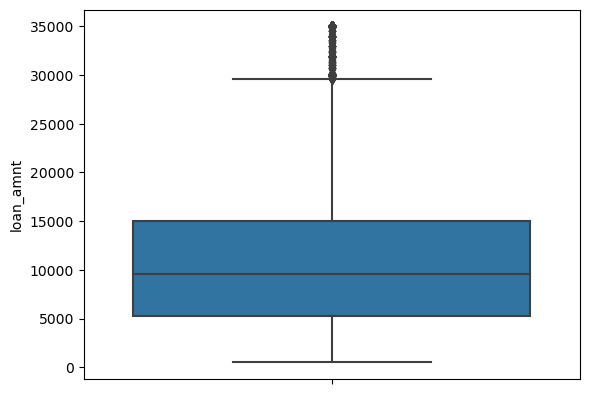

In [23]:
sns.boxplot(data=df, y='loan_amnt')

In [24]:
df = df[df['loan_amnt'] < 30000]

The upper fence for the box plot is around 30000, let us remove values that are above 30000.
Let's now look at `annual_inc`.

<Axes: ylabel='annual_inc'>

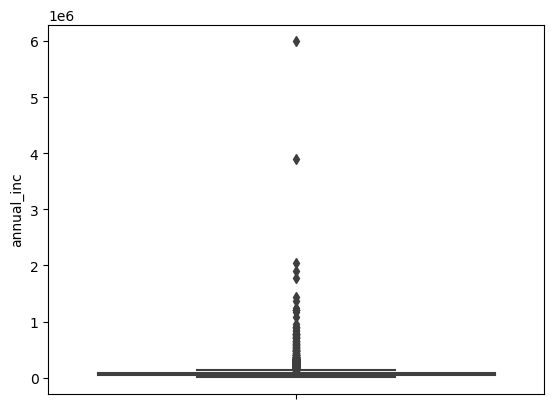

In [25]:
sns.boxplot(data=df, y='annual_inc')

In [26]:
df['annual_inc'].describe()

count    3.750500e+04
mean     6.714205e+04
std      6.293799e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.720000e+04
75%      8.000000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [27]:
np.quantile(df['annual_inc'], 0.95)

136156.79999999964

In [28]:
df = df[df['annual_inc'] < 137000]

We removed all values that are above the 95th quartile for `annual_inc` as people with such high annual incomes do not usually look for loans around 30000$.

In [29]:
len(df[df['loan_status']=='Fully Paid'])

30453

In [30]:
len(df[df['loan_status']=='Charged Off'])

5184

There is an imbalance in the dataset as data related to customers who have defaulted is less than customers who have paid the amount.

## Univariate / Segmented Univariate analysis

There are a few analysis templates that we will follow for categorical and numeric variables. Let us first write some custom functions that will do the calculations for us before we proceed with univariate analysis.

1) `Categorical variables`:- For categoric variables we will use a seaborn count plot that seperately shows number of defaulted and non defaulted customers for each of the categories of the variable. This is a very useful plot, but is NOT sufficient because there is an imbalance in the dataset. The number of defaulted customers are significantly less than the customers that have not defaulted, hence we would also need to analyse the proportion of people who defaulted for each category of the categorical variable. Let us first write the method.

In [31]:
def gatherProportions(frame, values, column_name):
    data = pd.DataFrame(columns=[column_name,'default_ratio','non_default_ratio'])
    for x in values:
        sub = frame[frame[column_name]==x]
        default_ratio = (len(sub[sub['loan_status']=='Charged Off'])/len(sub))*100
        non_default_ratio = 100.0 - default_ratio
        data.loc[len(data.index)] = [x, default_ratio, non_default_ratio]
    
    return data

In [32]:
def plotForCategoricalVariables(frame, column_name):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.countplot(data=frame, x=column_name, hue='loan_status', order=sorted(frame[column_name].unique()), ax=axes[0])
    axes[0].set_title('Count plot for ' + column_name + ' with respect to loan_status')
    
    proportions = gatherProportions(frame, sorted(frame[column_name].unique()), column_name)
    sns.barplot(data=proportions, x=column_name, y='default_ratio', order=sorted(frame[column_name].unique()), ax=axes[1])
    axes[1].set_title('Percentage of people that defaulted')
    plt.tight_layout()
    plt.show()

In [69]:
def plotForCategoricalVariablesYAxis(frame, column_name):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    sns.countplot(data=frame, y=column_name, hue='loan_status', order=sorted(frame[column_name].unique()), ax=axes[0])
    axes[0].set_title('Count plot for ' + column_name + ' with respect to loan_status')
    
    proportions = gatherProportions(frame, sorted(frame[column_name].unique()), column_name)
    sns.barplot(data=proportions, y=column_name, x='default_ratio', order=sorted(frame[column_name].unique()), ax=axes[1])
    axes[1].set_title('Percentage of people that defaulted')
    plt.tight_layout()
    plt.show()

2) `Numeric variables`:- We will use segmented univariate box plots to analyse the distribution of the variable for each `loan_status`. We will also qdcut the numeric variable and analyse the percentage of people who defaulted for each cut.

In [34]:
def plotForNumericVariables(df, col1):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    sns.boxplot(data=df, x=col1, y='loan_status', ax=axes[0])
    
    df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    paid_pivot = pd.pivot_table(data=df[df['loan_status']=='Fully Paid'], index=col1+'_bucket', values='id', aggfunc='count')
    default_pivot = pd.pivot_table(data=df[df['loan_status']=='Charged Off'], index=col1+'_bucket', values='id', aggfunc='count')
    proportion_df = default_pivot.divide(paid_pivot.add(default_pivot))
    sns.barplot(data=proportion_df, x=proportion_df.index, y='id', ax=axes[1])
    df.drop(col1+'_bucket', axis=1, inplace=True)
    plt.tight_layout()
    plt.show()

In [35]:
sns.set_style('darkgrid')

Let us begin the process of univariate analysis.

## Int_Rate

Interest rate determines the extra percentage principal amount that the customer would need to repay the bank after the term completes.

In [37]:
df['int_rate'].isna().sum()

0

<Axes: xlabel='int_rate'>

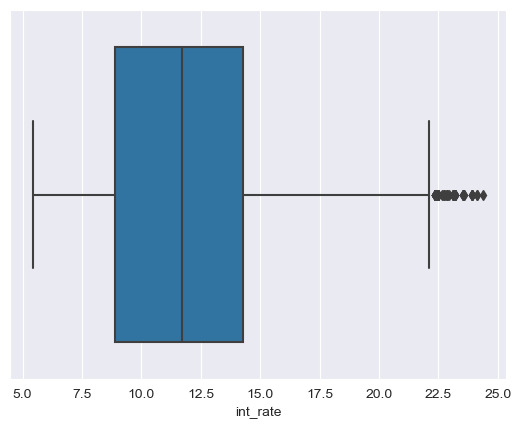

In [38]:
sns.boxplot(data=df, x='int_rate')

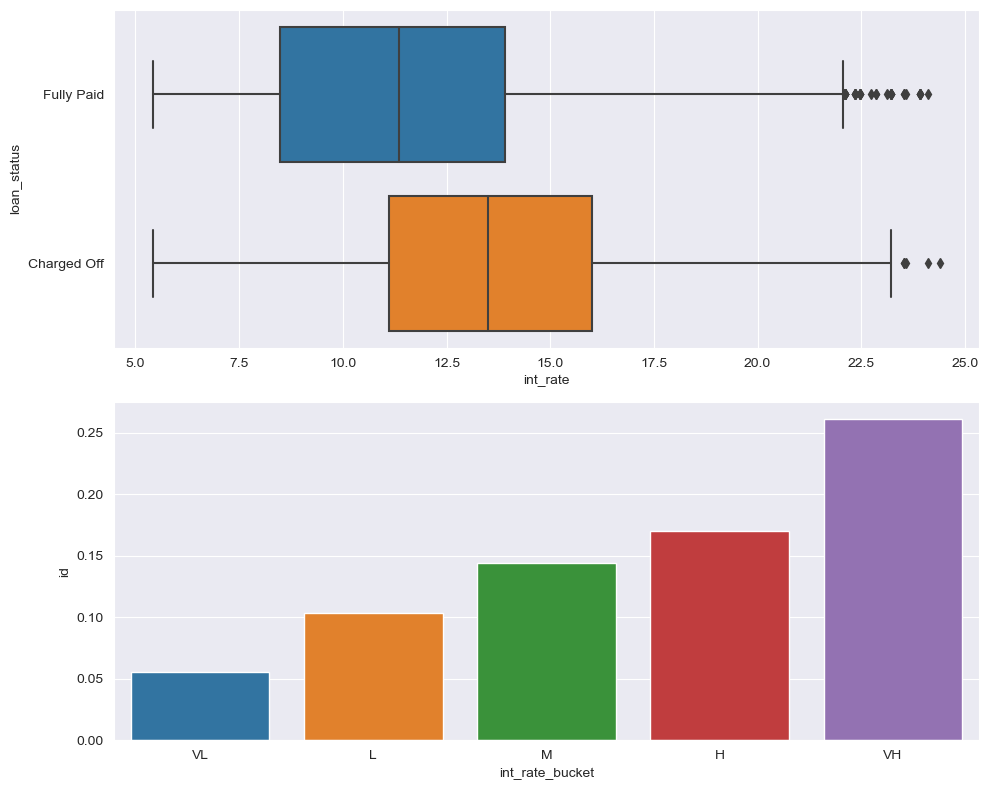

In [39]:
plotForNumericVariables(df, 'int_rate')

There is a very clear indicator here. The box plot indicates that the median interest rate for customers who defaulted is significantly higher than customers who paid the loans. The 2nd plot, shows that as the interest rate increases from VL (Very Low) to (Very High), the percentage of people who defaulted keeps increase on every step. **Higher interest implies a higher chance that customer would default on the loans**.

## Loan_Amnt

In [40]:
df['loan_amnt'].isna().sum()

0

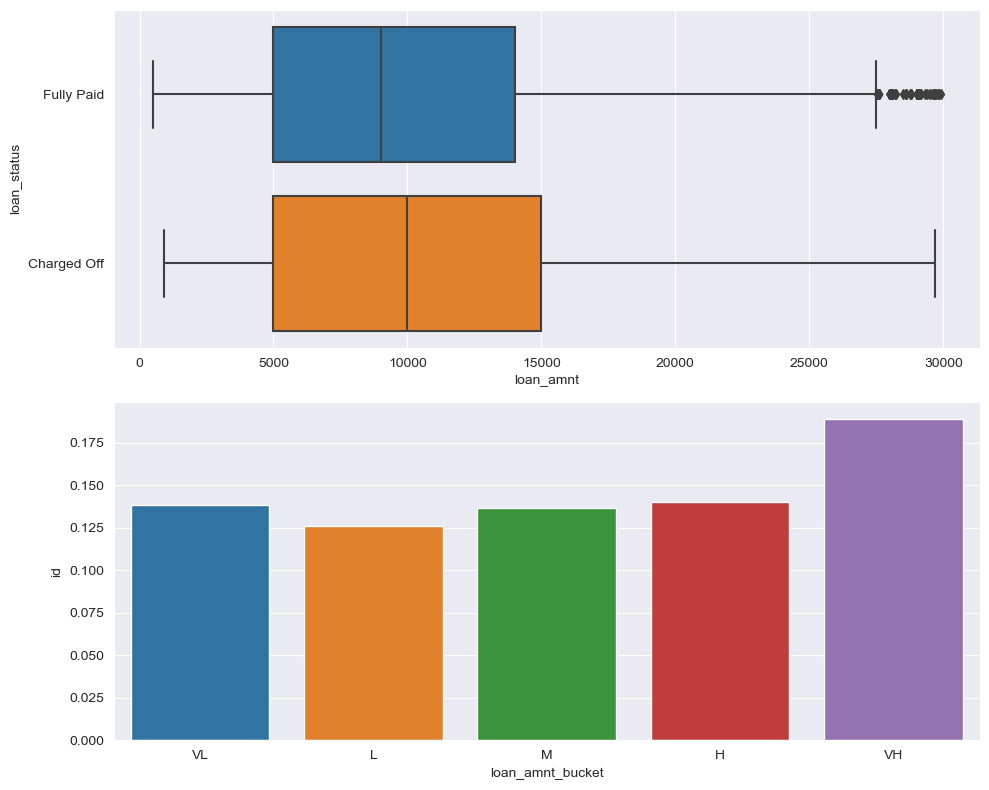

In [41]:
plotForNumericVariables(df, 'loan_amnt')

`loan_amnt` does not seem to be a strong indicator of default. We can see here that for loan_amnts low to high, the distribution is approximately uniform.

## funded_amnt

This variable indicates the total amount of loan committed by the bank to the loan. On manual inspection in most cases this is similar to loan_amnt as expected, hence there seems to be a high degree of correlation between this variable and loan_amnt.

In [42]:
df['loan_amnt'].corr(df['funded_amnt'])

0.9813592965157907

The same seems to be the case with `funded_amnt_inv` which is the total amount funded by investors of the bank on the loan and `total_payment` which is the final amount to be paid back, which are proportional to the loan amount obtained.

In [43]:
df['loan_amnt'].corr(df['funded_amnt_inv'])

0.9280607884238207

In [44]:
df['loan_amnt'].corr(df['total_pymnt'])

0.8757200498714749

We will hence not independently consider these for analysis and will instead use `loan_amnt`.

## Term

In [45]:
df['term'].isna().sum()

0

In [46]:
plt.subplots_adjust(bottom=0.4, top=0.6)

<Figure size 640x480 with 0 Axes>

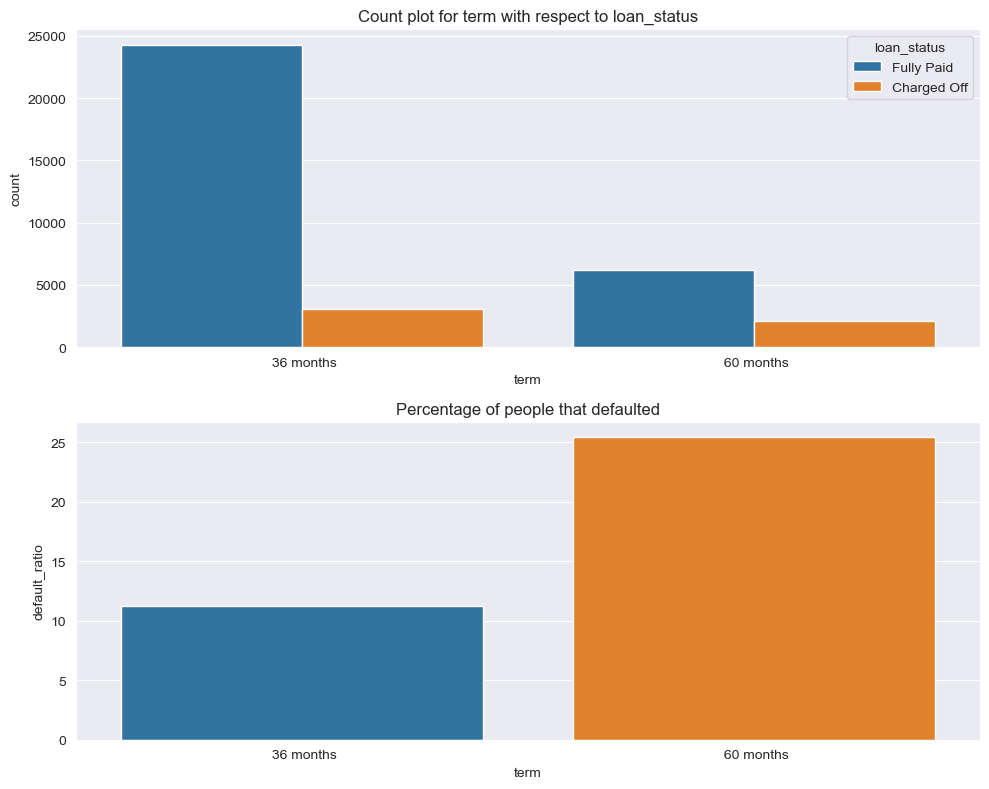

In [47]:
plotForCategoricalVariables(df, 'term')

The term does not seem to be a strong indicator of default, but its noteworthy that customers with a 60 month term have a 25% chance of default.

## Annual_Inc

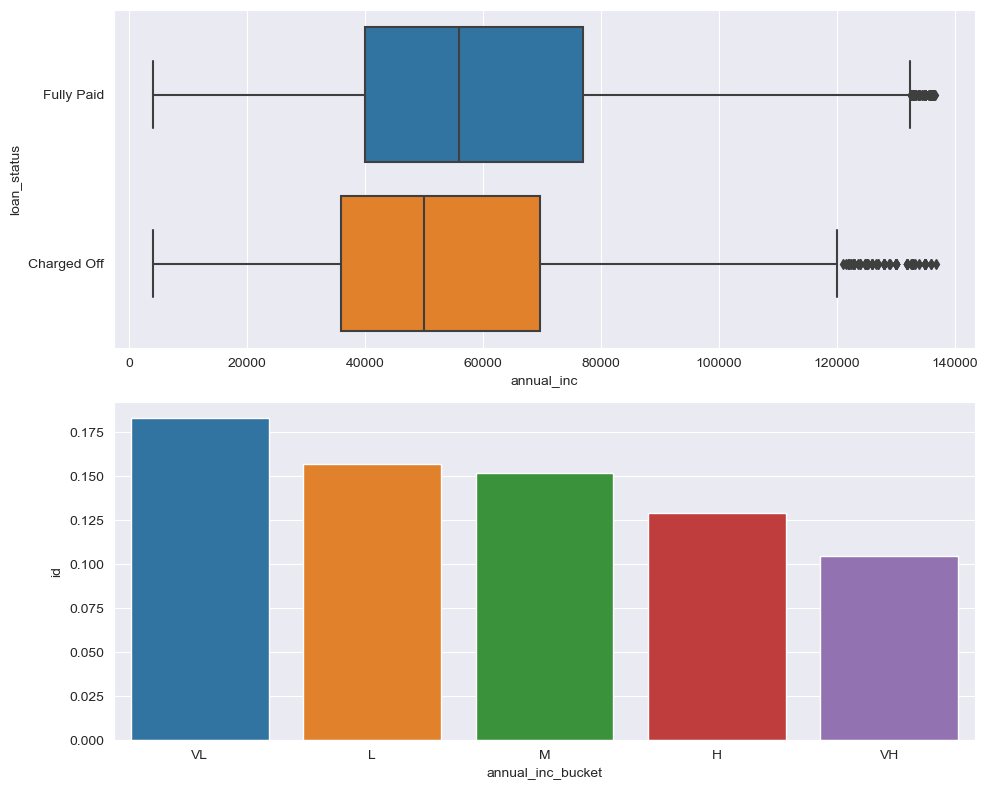

In [48]:
plotForNumericVariables(df, 'annual_inc')

The median value for annual_inc for people who defaulted is less than people who paid the loans. The second graph also indicates that as the annual_inc increases, the chances of default decreases. **A higher annual income would mean that, the more the savings the customer can make towards the loan and hence a higher chance that the loan is paid**.

## Installments

In [49]:
df['installment'].corr(df['loan_amnt'])

0.928758092115028

Higher the loan_amnt, higher the installment to pay monthly, hence we ignore this column.

## Grade

In [50]:
df['grade'].isna().sum()

0

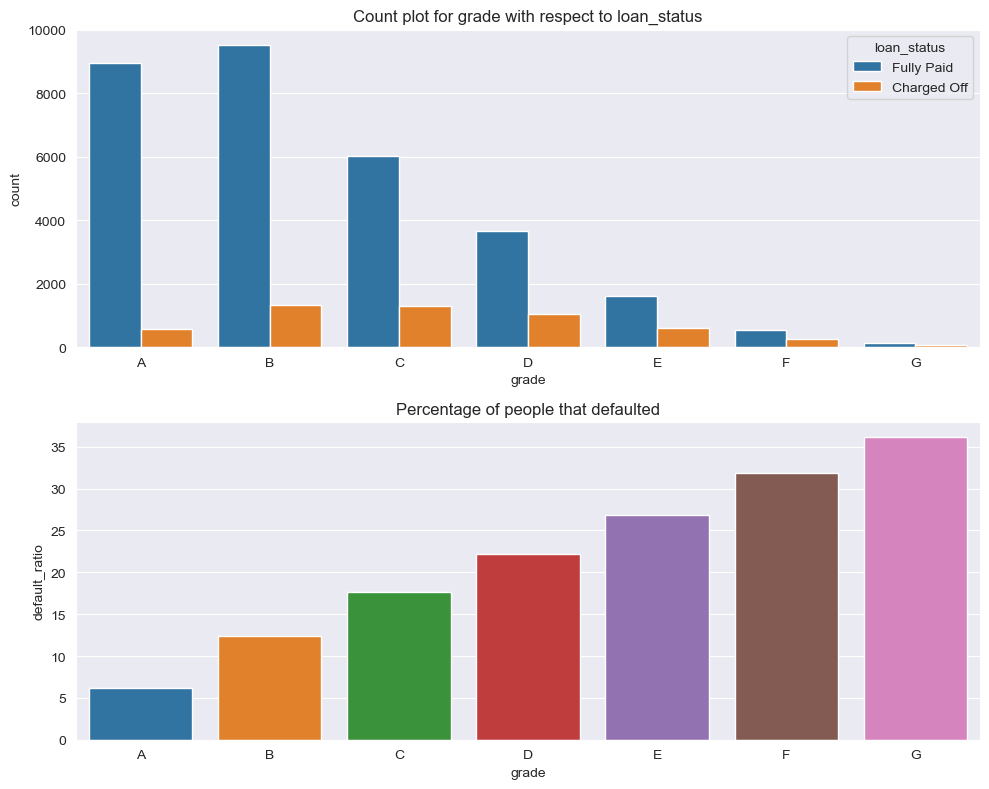

In [51]:
plotForCategoricalVariables(df, 'grade')

Grade is an ordered categorical variable. The second graph clearly indicates that as the grade increases alphabetically the higher the chance of default. **Higher grade means higher risk, which clearly indicates a higher chance that the customer defaults**.

## sub_grade

In [52]:
df['sub_grade'].isna().sum()

0

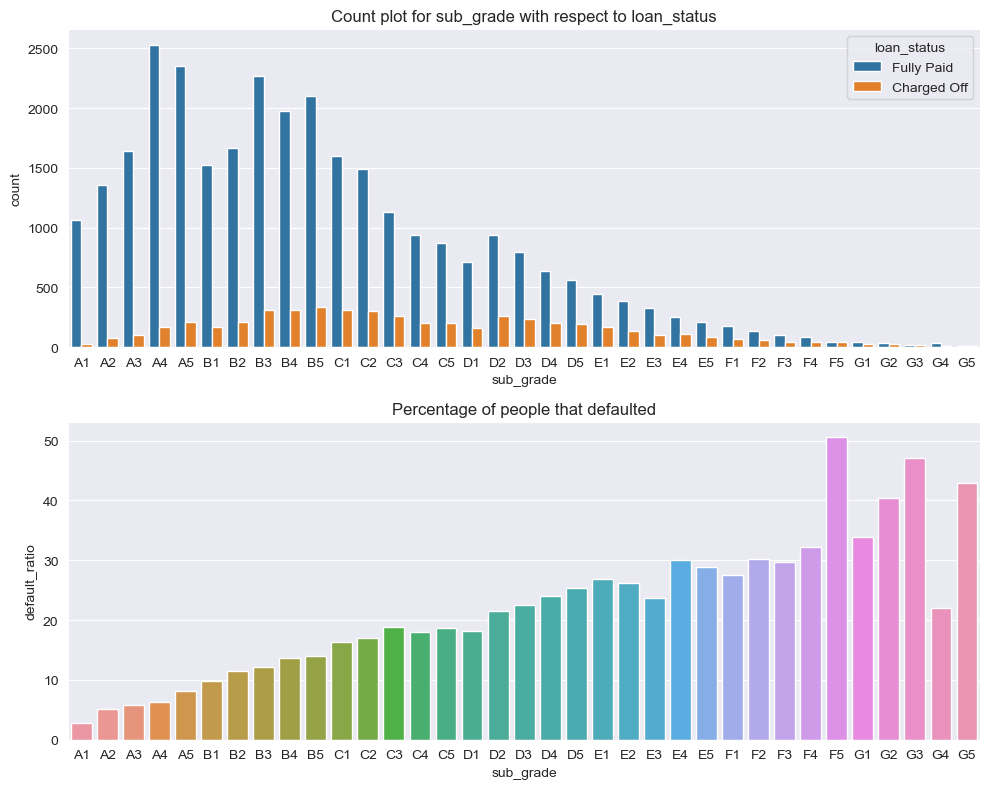

In [53]:
plotForCategoricalVariables(df, 'sub_grade')

sub_grade is an ordered categorical variable. Within a grade as the number increases the higher the chance of risk. A5 is more riskier than A4 is more riskier than A3 and so on. You can see this trend in the second graph. Although, there are a few exceptions the trend is maintained convincingly. **Higher the subgrade within a grade, higher the chance that a customer defaults**.

## Emp_Title

In [54]:
df['emp_title'].isna().sum()

2140

In [55]:
df['emp_title'].value_counts()

US Army                                                                           122
Bank of America                                                                   103
AT&T                                                                               53
US Air Force                                                                       51
UPS                                                                                49
Wells Fargo                                                                        48
IBM                                                                                47
Kaiser Permanente                                                                  47
USAF                                                                               47
Walmart                                                                            43
United States Air Force                                                            40
Self Employed                                         

## emp_length

In [56]:
df['emp_length'].isna().sum()

1002

In [57]:
df['emp_length'].value_counts()

10+ years    7481
< 1 year     4243
2 years      4034
3 years      3745
4 years      3122
1 year       2997
5 years      2966
6 years      2020
7 years      1599
8 years      1298
9 years      1130
Name: emp_length, dtype: int64

In [58]:
df['emp_length'] =  df['emp_length'].astype('str')

In [59]:
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace('< ', '0-'))
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace(' years', ''))
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace(' year', ''))
df['emp_length'] = df['emp_length'].apply(lambda x: x.replace('+', ''))

temp_df = df[df['emp_length']!='nan']

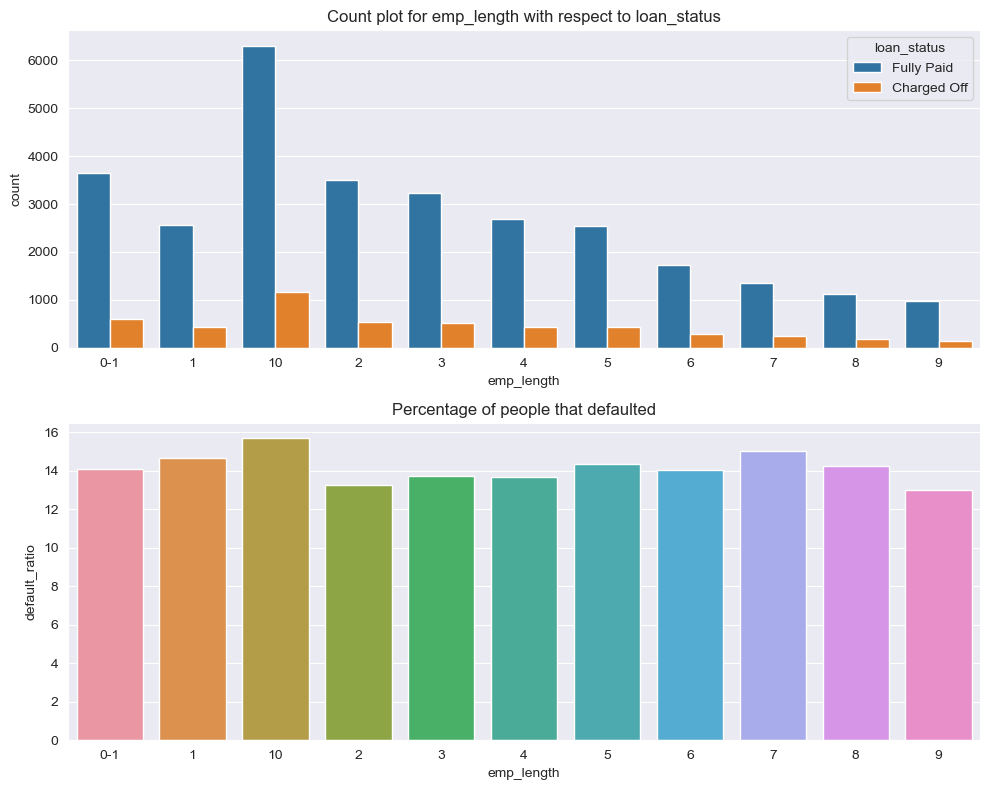

In [60]:
plotForCategoricalVariables(temp_df, 'emp_length')

There is not a lot of difference in the percentage of people who defaulted with the employment length

## Home Ownership

In [61]:
df['home_ownership'].isna().sum()

0

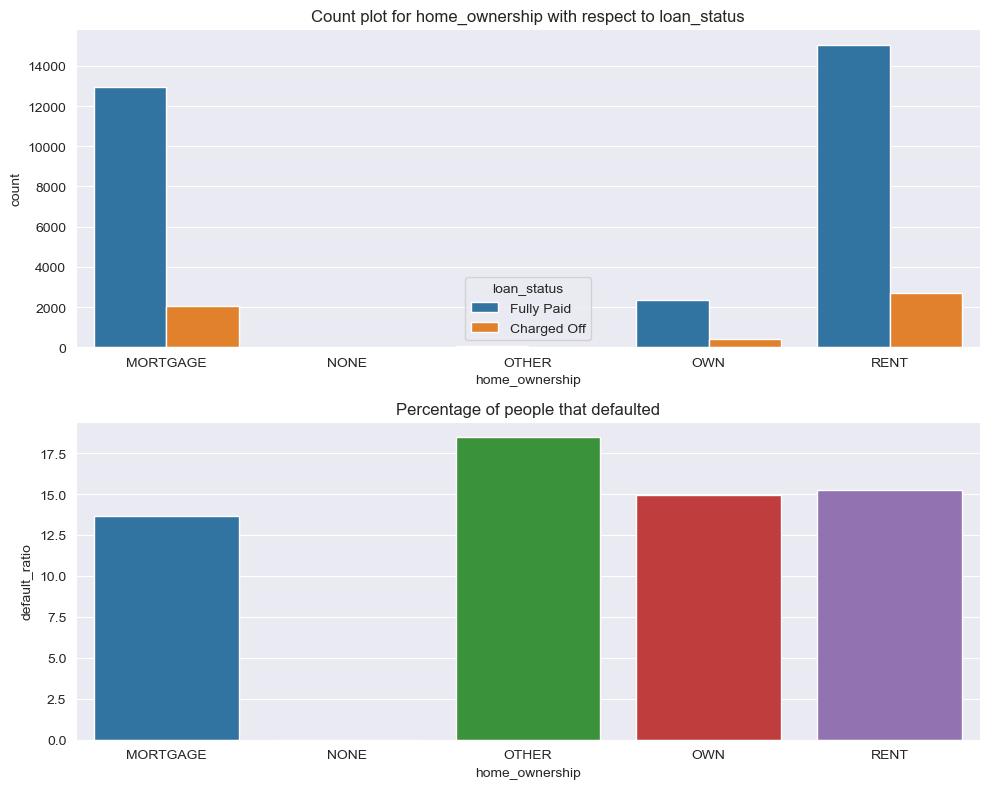

In [62]:
plotForCategoricalVariables(df, 'home_ownership')

There is not a lot of difference in the percentage of people who defaulted with the home_ownership.

## Verification_Status

In [63]:
df['verification_status'].isna().sum()

0

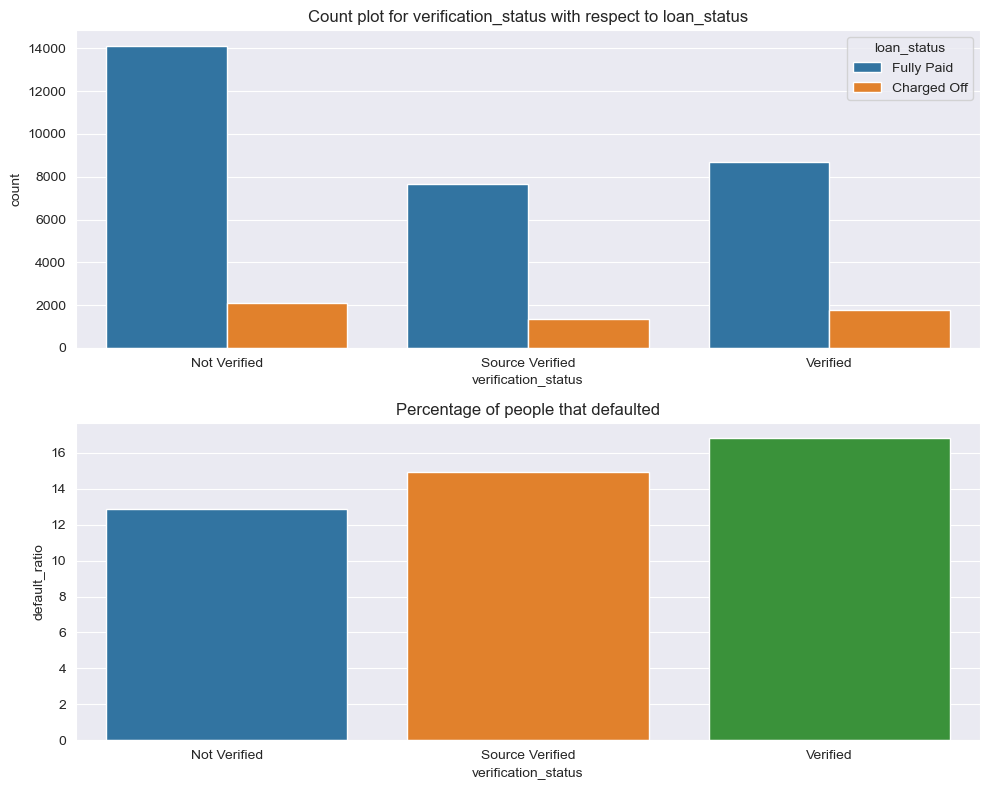

In [65]:
plotForCategoricalVariables(df, 'verification_status')

No indicators

## Purpose

In [66]:
df['purpose'].isna().sum()

0

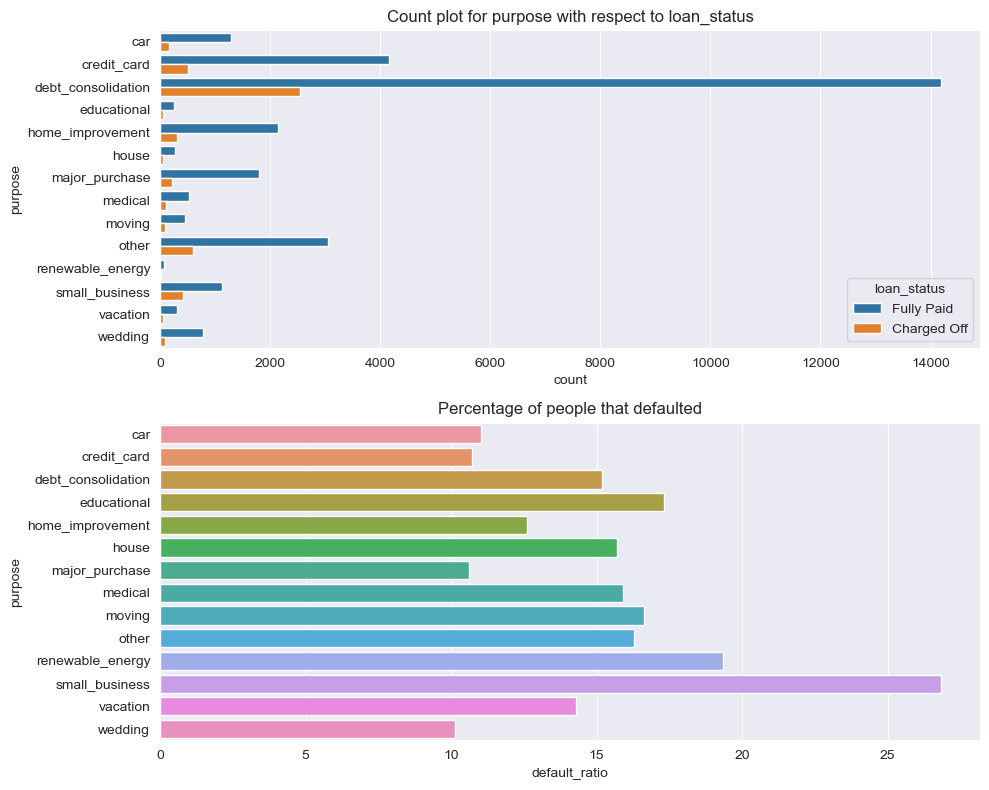

In [70]:
plotForCategoricalVariablesYAxis(df, 'purpose')

## Addr_State

In [71]:
df['addr_state'].isna().sum()

0

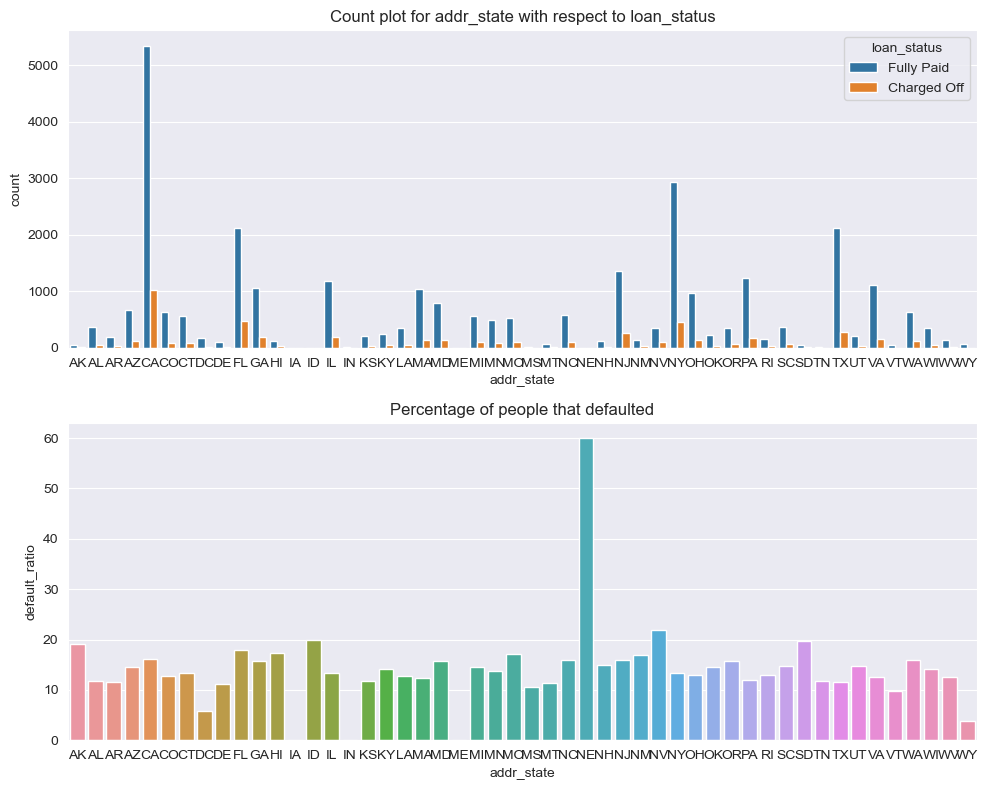

In [73]:
plotForCategoricalVariables(df, 'addr_state')

In [77]:
gatherProportions(df, sorted(df['addr_state'].unique()), 'addr_state').sort_values(by='default_ratio', ascending=False)

addr_state  default_ratio  non_default_ratio
28         NE      60.000000          40.000000
32         NV      21.846847          78.153153
13         ID      20.000000          80.000000
40         SD      19.672131          80.327869
0          AK      19.117647          80.882353
9          FL      18.003084          81.996916
11         HI      17.307692          82.692308
24         MO      17.115689          82.884311
31         NM      16.860465          83.139535
4          CA      16.146731          83.853269
46         WA      15.947712          84.052288
27         NC      15.873016          84.126984
30         NJ      15.851393          84.148607
36         OR      15.839243          84.160757
10         GA      15.785256          84.214744
20         MD      15.705128          84.294872
29         NH      14.965986          85.034014
43         UT      14.830508          85.169492
39         SC      14.685315          85.314685
3          AZ      14.575412          85.424588
35         OK      14.492754          85.507246
22         MI      14.481707          85.518293
17         KY      14.237288          85.762712
47         WI      14.111922          85.888078
23         MN      13.684211          86.315789
14         IL      13.460132          86.539868
6          CT      13.446677          86.553323
33         NY      13.376739          86.623261
38         RI      12.972973          87.027027
34         OH      12.914798          87.085202
18         LA      12.722646          87.277354
5          CO      12.691771          87.308229
44         VA      12.667191          87.332809
48         WV      12.500000          87.500000
19         MA      12.363331          87.636669
37         PA      12.043011          87.956989
16         KS      11.814346          88.185654
41         TN      11.764706          88.235294
1          AL      11.735941          88.264059
2          AR      11.607143          88.392857
42         TX      11.548117          88.451883
26         MT      11.392405          88.607595
8          DE      11.111111          88.888889
25         MS      10.526316          89.473684
45         VT       9.803922          90.196078
7          DC       5.913978          94.086022
49         WY       3.846154          96.153846
21         ME       0.000000         100.000000
15         IN       0.000000         100.000000
12         IA       0.000000         100.000000

We see that Nebraska has 60% default ratio which is the maximum default ratio for any state.

In [79]:
len(df[df['addr_state']=='NE'])

5

But, it turns out that there are only 5 rows that are based on Nebraska which is not enough to derive a conclusuion.

## DTI

Debt to Income ratio compares how much you owe to how much you spend every year. A low DTI means that your earnings are much higher than your expenditure.

In [80]:
df['dti'].isna().sum()

0

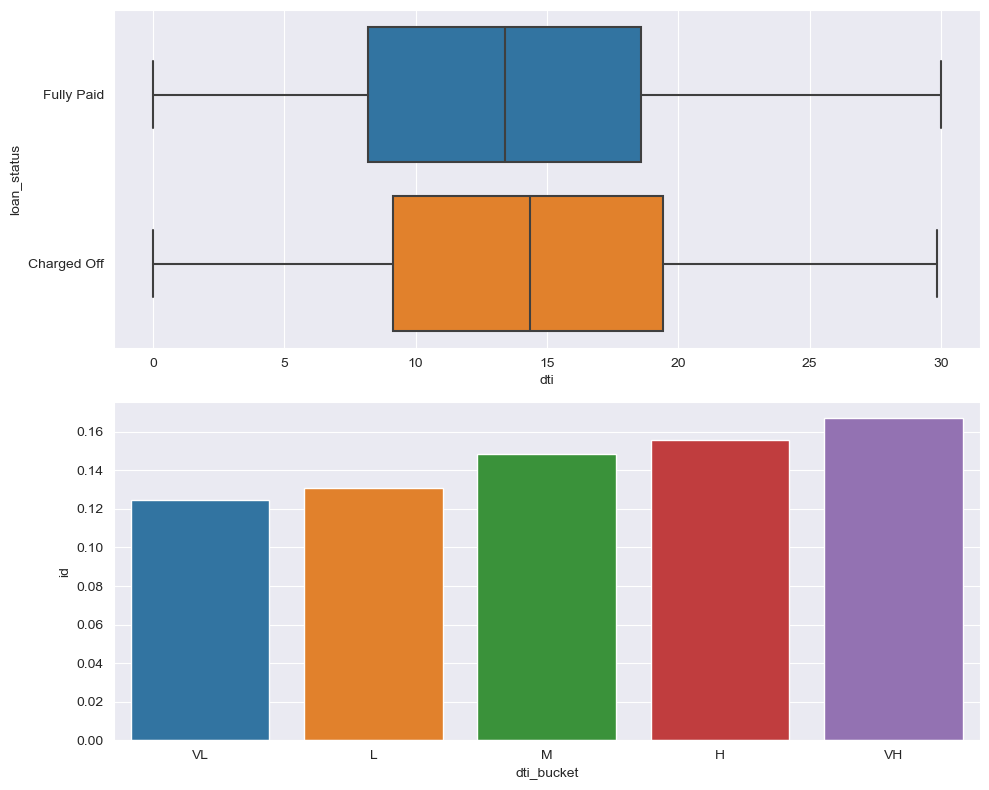

In [81]:
plotForNumericVariables(df, 'dti')

The median dti for people who defaulted is slightly higher than the median dti of people who paid the loans indicating that people who failed to pay their loans owed more each month in comparison to their income than the people who completed their loans. The second graph also shows that as the DTI increases, the percentage of people who default also increases. **DTI is a good indicator of the financial situation of the person, the lower the DTI, the more they are able to save and higher the chances that their loan is repaid.**

## Open Accounts

In [82]:
df['open_acc'].isna().sum()

0

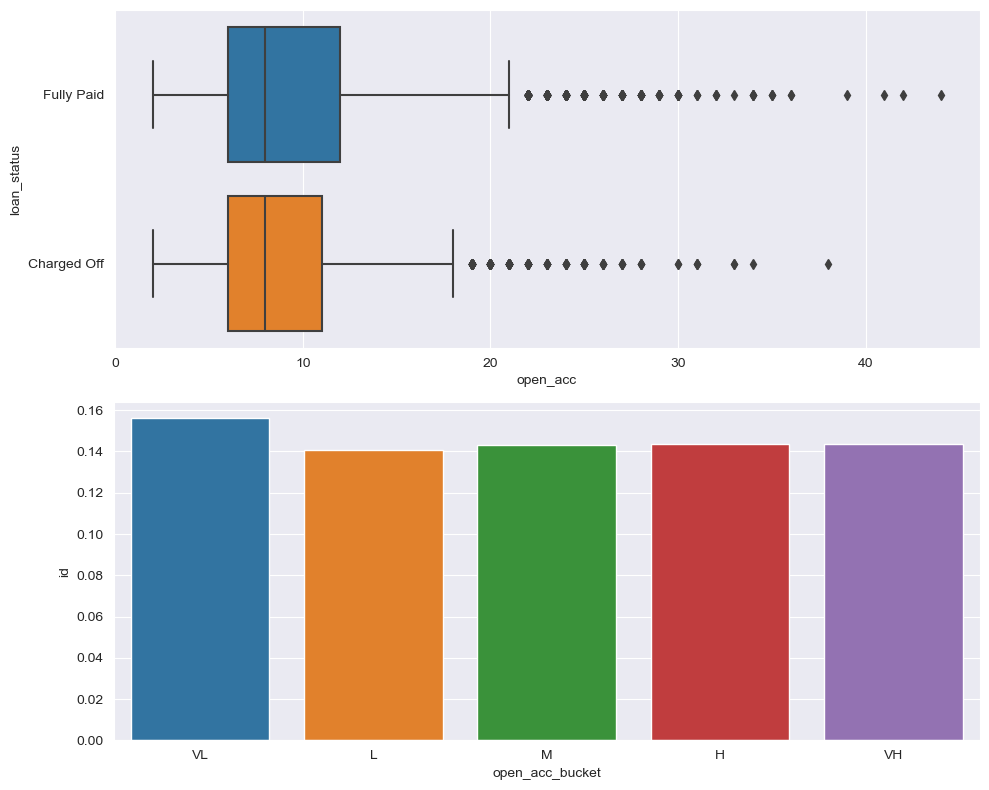

In [84]:
plotForNumericVariables(df, 'open_acc')

Relatively same median values, not a lot of difference because of the number of open accounts.

## pub_rec

In [86]:
df['pub_rec'].isna().sum()

0

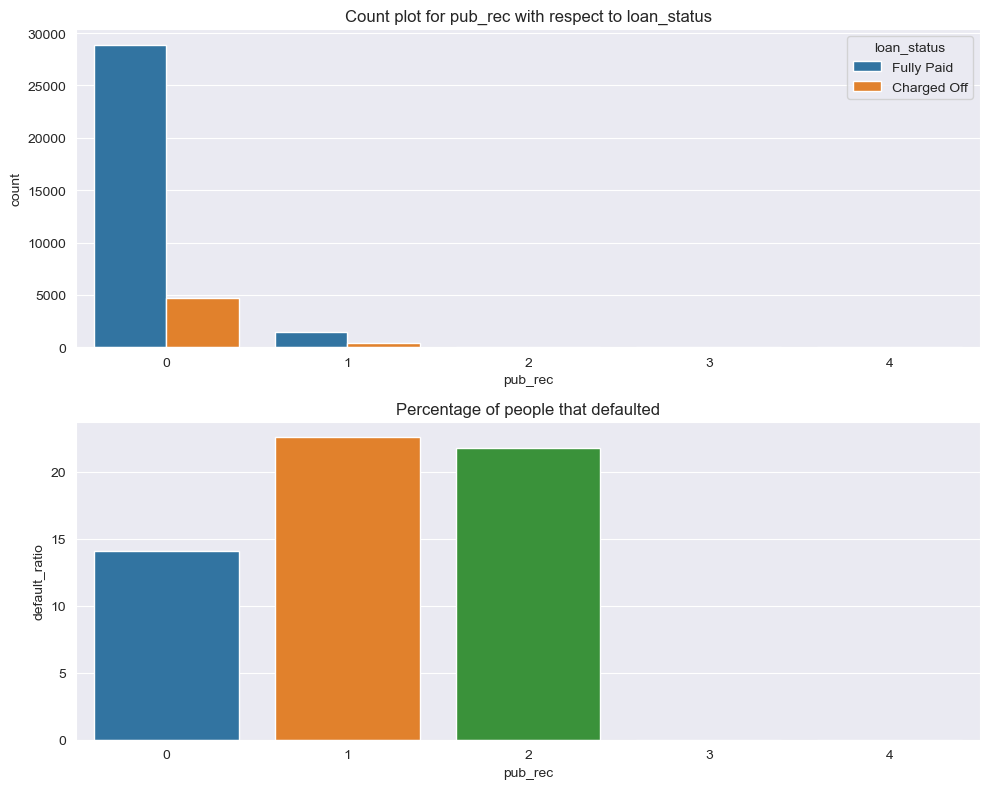

In [88]:
plotForCategoricalVariables(df, 'pub_rec')

In [89]:
df['pub_rec'].value_counts()

0    33647
1     1936
2       46
3        6
4        2
Name: pub_rec, dtype: int64

There are too few derogatory records greater than 1. For 1 derogatory record, around 22% of people have defaulted.

## revol_bal

In [90]:
df['revol_bal'].isna().sum()

0

<Axes: xlabel='revol_bal'>

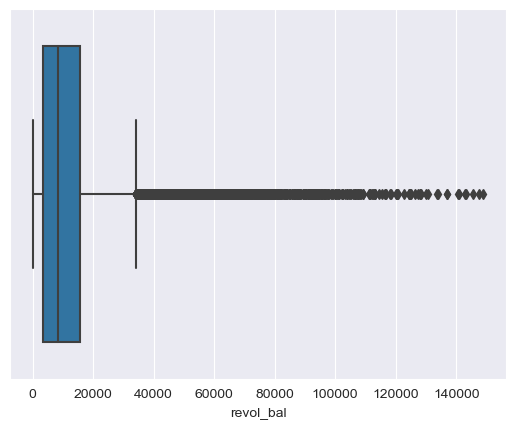

In [91]:
sns.boxplot(x=df['revol_bal'])

In [92]:
np.quantile(df['revol_bal'], 0.95)

35377.399999999994

C:\Users\davadhani\AppData\Local\Temp\ipykernel_31052\3083820597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
C:\Users\davadhani\AppData\Local\Temp\ipykernel_31052\3083820597.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col1+'_bucket', axis=1, inplace=True)


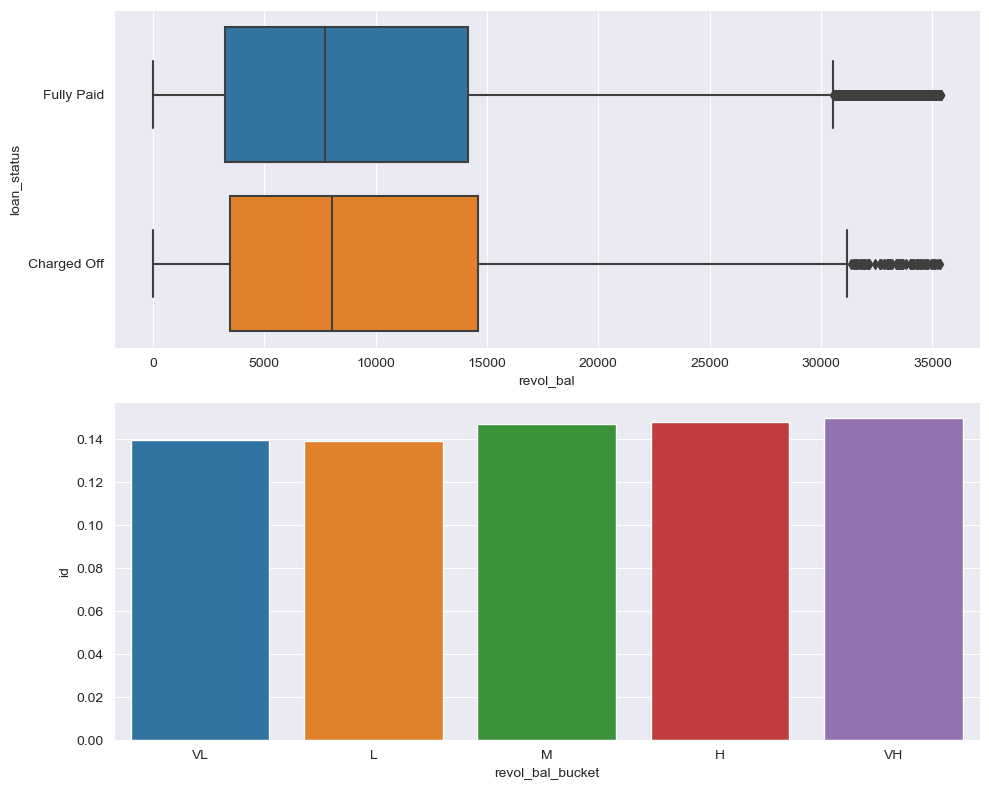

In [93]:
plotForNumericVariables(df[df['revol_bal']<35377], 'revol_bal')

No significant difference with revol_bal

## Revol_Util

Revolving utilization compares the balance on each of your credit cards to your credit limit.

In [94]:
df['revol_util'].isna().sum()

48

<Axes: xlabel='revol_util'>

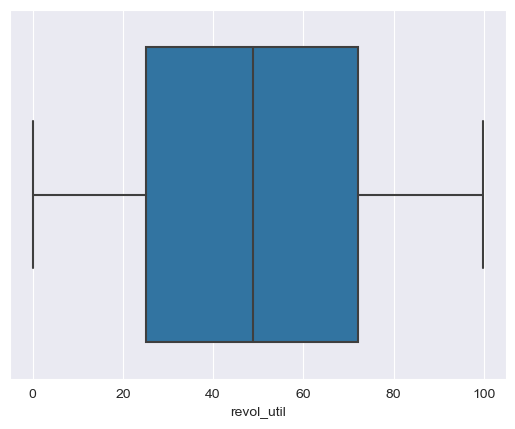

In [100]:
sns.boxplot(x=df['revol_util'])

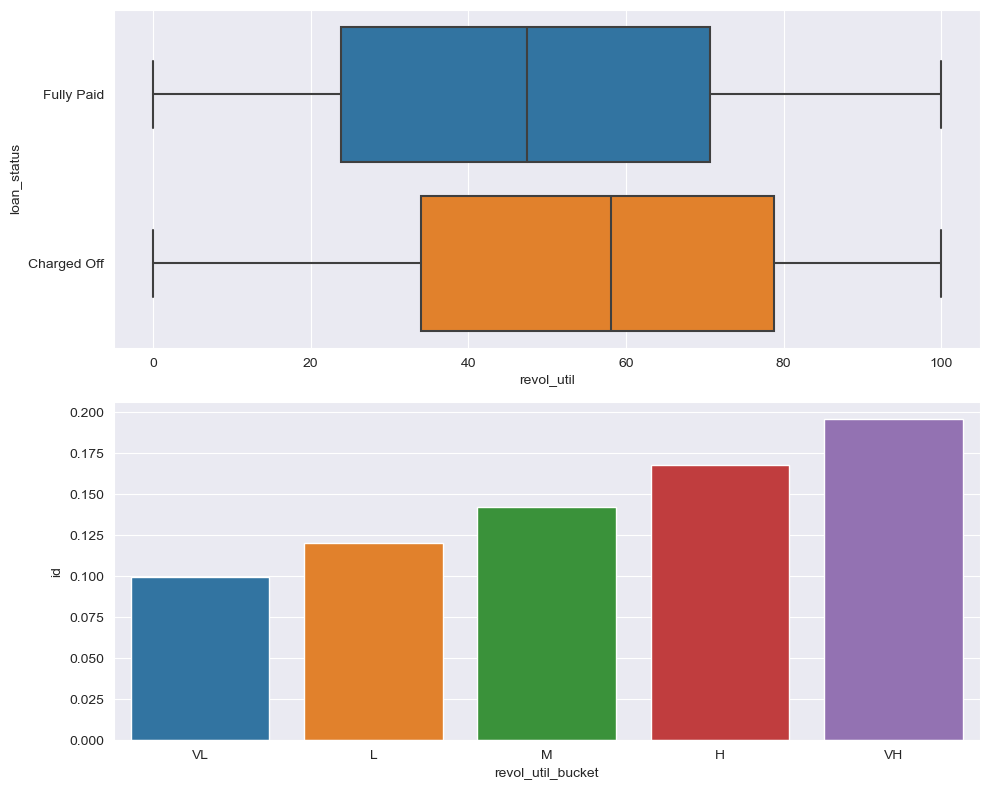

In [101]:
plotForNumericVariables(df, 'revol_util')

In [104]:
df[df['loan_status']=='Charged Off']['revol_util'].describe()

count    5168.000000
mean       55.321976
std        27.902949
min         0.000000
25%        34.000000
50%        58.100000
75%        78.725000
max        99.900000
Name: revol_util, dtype: float64

In [103]:
df[df['loan_status']!='Charged Off']['revol_util'].describe()

count    30421.000000
mean        47.449611
std         28.188689
min          0.000000
25%         23.900000
50%         47.400000
75%         70.600000
max         99.900000
Name: revol_util, dtype: float64

Median value for `revol_util` for people who defaulted is 58% which is much higher then 47% revol_util for people who have paid their loans. Indicating that people who default usually have a much higher creadit utilization. **Higher the creadit utilization, higher the chance that the customer might default which is evident from both graphs**.

## Total accounts

In [105]:
df['total_acc'].isna().sum()

0

<Axes: xlabel='total_acc'>

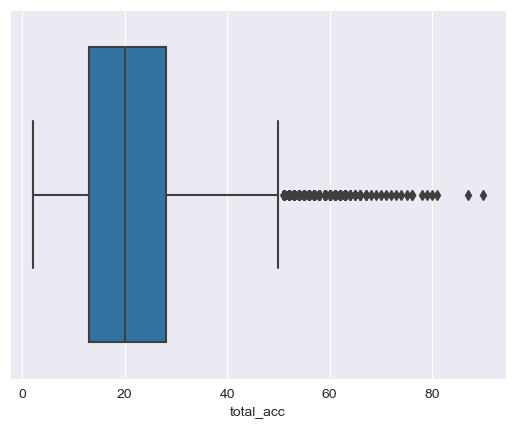

In [106]:
sns.boxplot(x=df['total_acc'])

C:\Users\davadhani\AppData\Local\Temp\ipykernel_31052\3083820597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
C:\Users\davadhani\AppData\Local\Temp\ipykernel_31052\3083820597.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col1+'_bucket', axis=1, inplace=True)


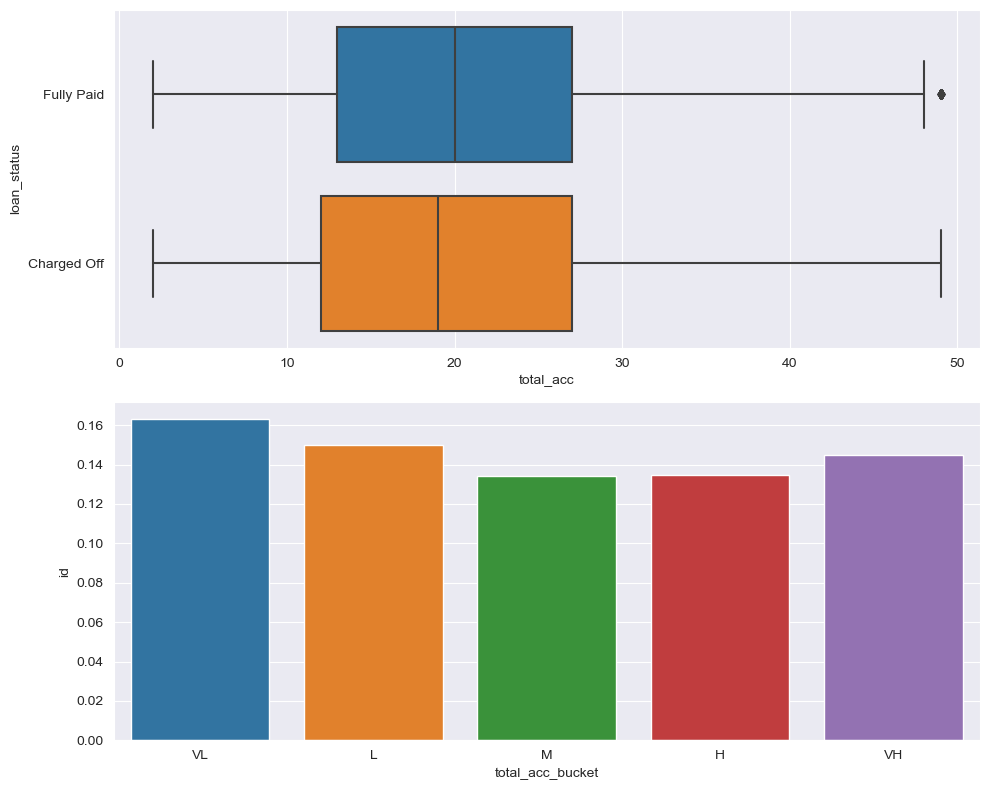

In [108]:
plotForNumericVariables(df[df['total_acc']<50],'total_acc')

No strong trend

## total_rec_late_fee

In [109]:
df['total_rec_late_fee'].isna().sum()

0

<Axes: xlabel='total_rec_late_fee'>

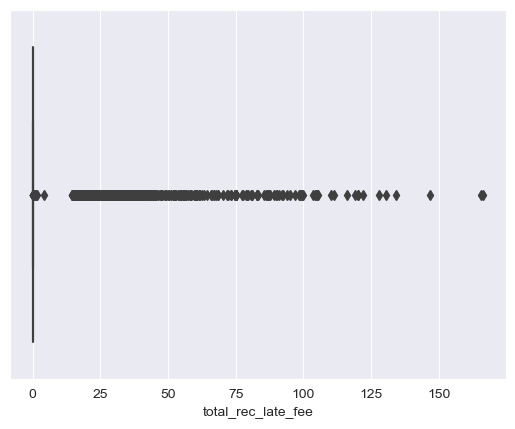

In [110]:
sns.boxplot(x=df['total_rec_late_fee'])

Under most scenarios the late fees paid is 0. However, let's see of the people who have paid the late fees, how many of them default.

C:\Users\davadhani\AppData\Local\Temp\ipykernel_31052\3083820597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
C:\Users\davadhani\AppData\Local\Temp\ipykernel_31052\3083820597.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(col1+'_bucket', axis=1, inplace=True)


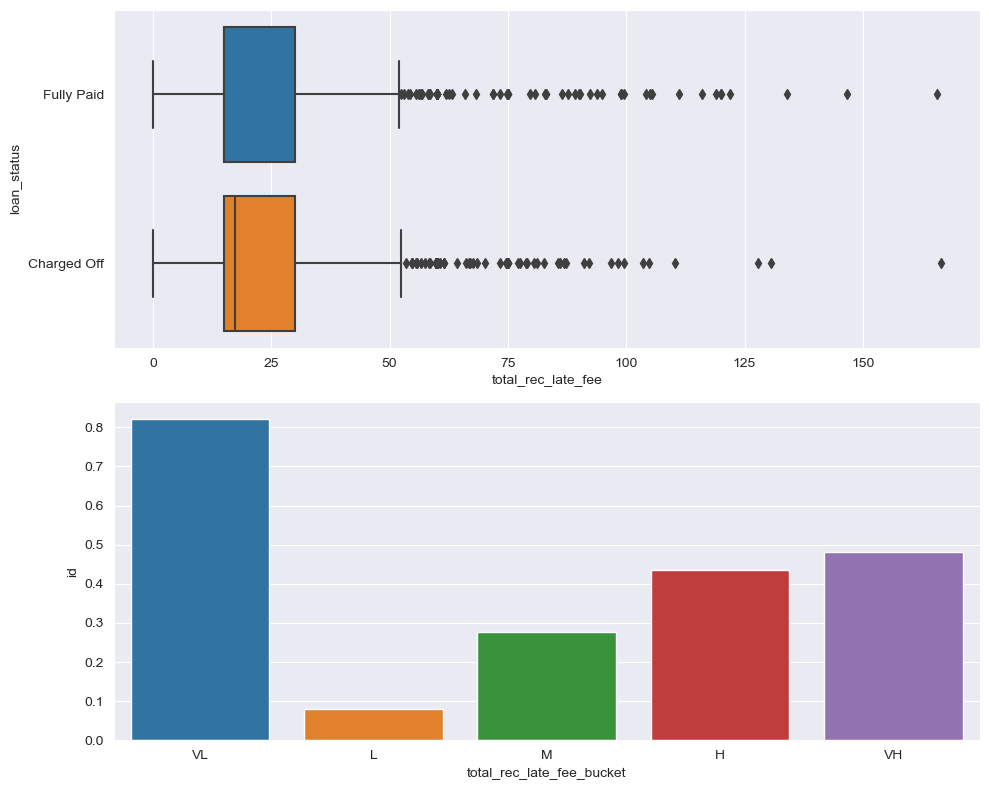

In [114]:
plotForNumericVariables(df[df['total_rec_late_fee']>0], 'total_rec_late_fee')

## pub_rec_bankruptcies

In [115]:
df['pub_rec_bankruptcies'].isna().sum()

657

In [116]:
df['pub_rec_bankruptcies'].value_counts()

0.0    33400
1.0     1575
2.0        5
Name: pub_rec_bankruptcies, dtype: int64

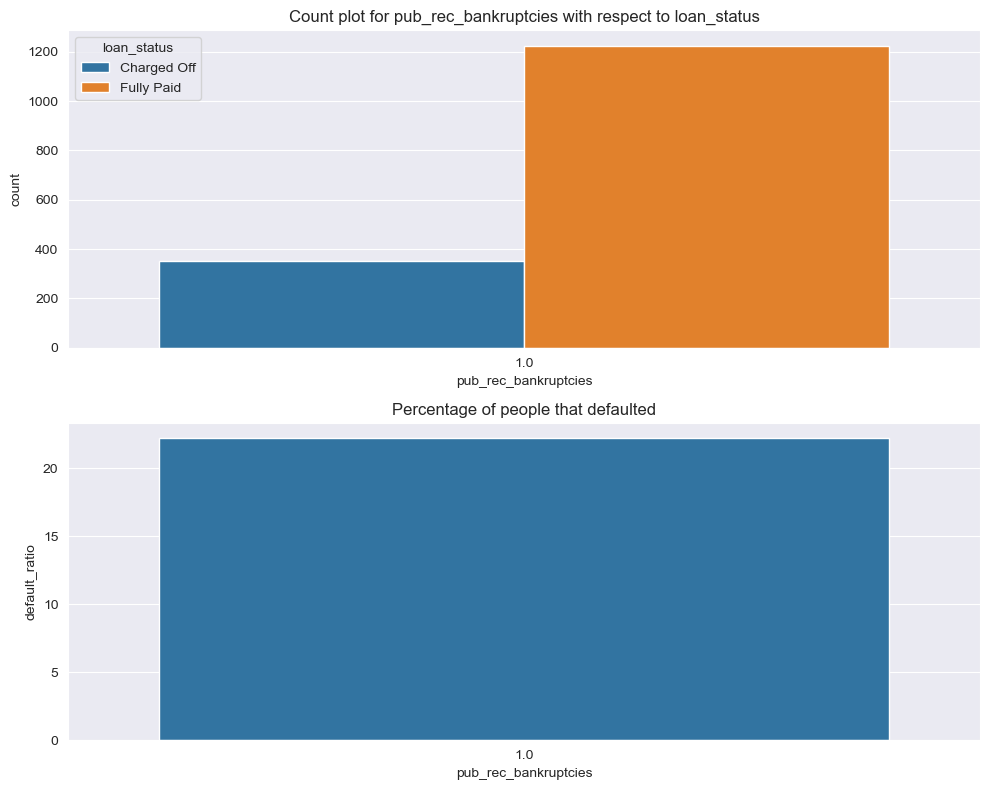

In [124]:
plotForCategoricalVariables(df[df['pub_rec_bankruptcies']==1], 'pub_rec_bankruptcies')

# Data Driven Metrics

There are 2 possible metrics that can be derived from the existing data given to us.
1) What percent of the loan amnt is the customer's salary which is a data driven metric.The higher the percentage of the loan amount with respect to income, we expect that the percentage of default might increase too.
2) Derive day, month and year from date and evaluate the results.

In [125]:
df['percent'] = (df['loan_amnt']/df['annual_inc'])*100

## Percent

<Axes: xlabel='percent'>

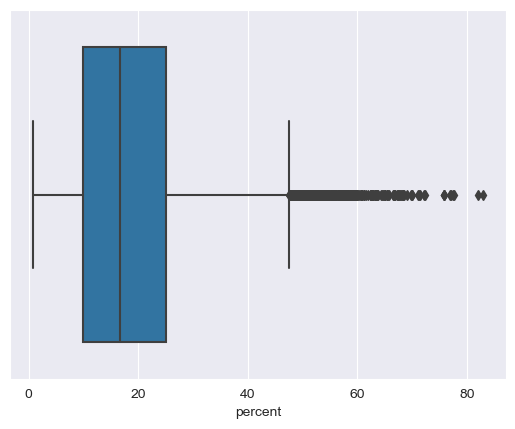

In [126]:
sns.boxplot(x=df['percent'])

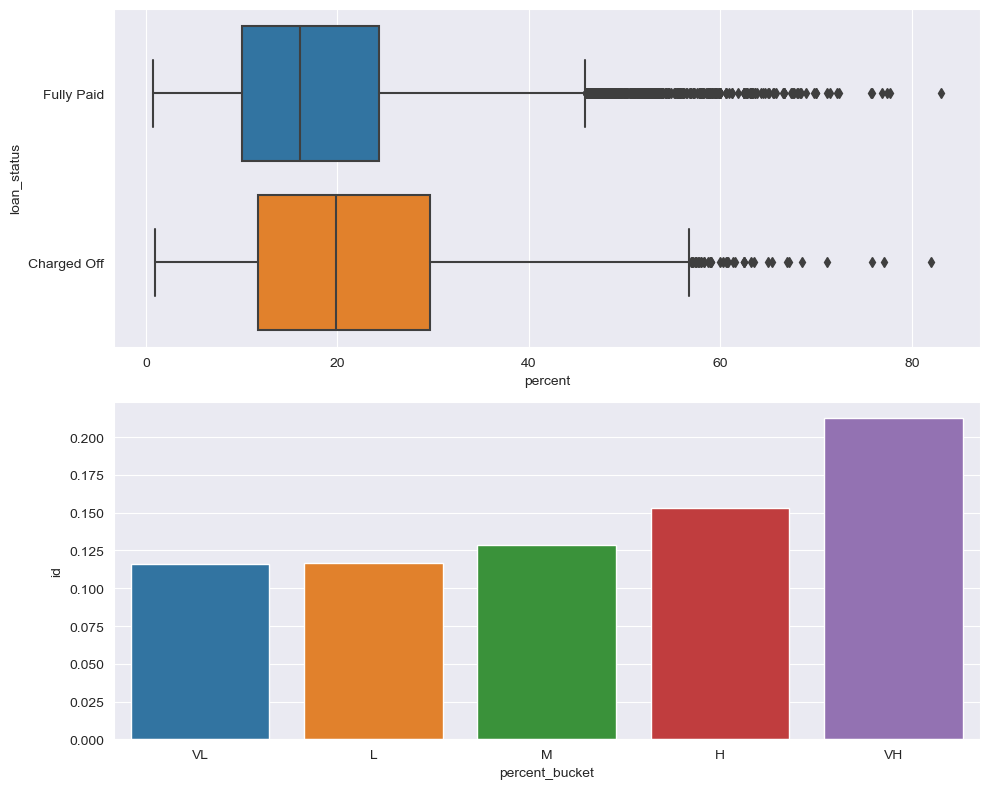

In [127]:
plotForNumericVariables(df, 'percent')

As a higher percentage of income is provided as a loan, the higher the percentage of default.

## Issued Date

In [134]:
from datetime import datetime
import calendar
df['month']=df['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y').strftime('%b'))

In [135]:
df['year']=df['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y').strftime('%y'))

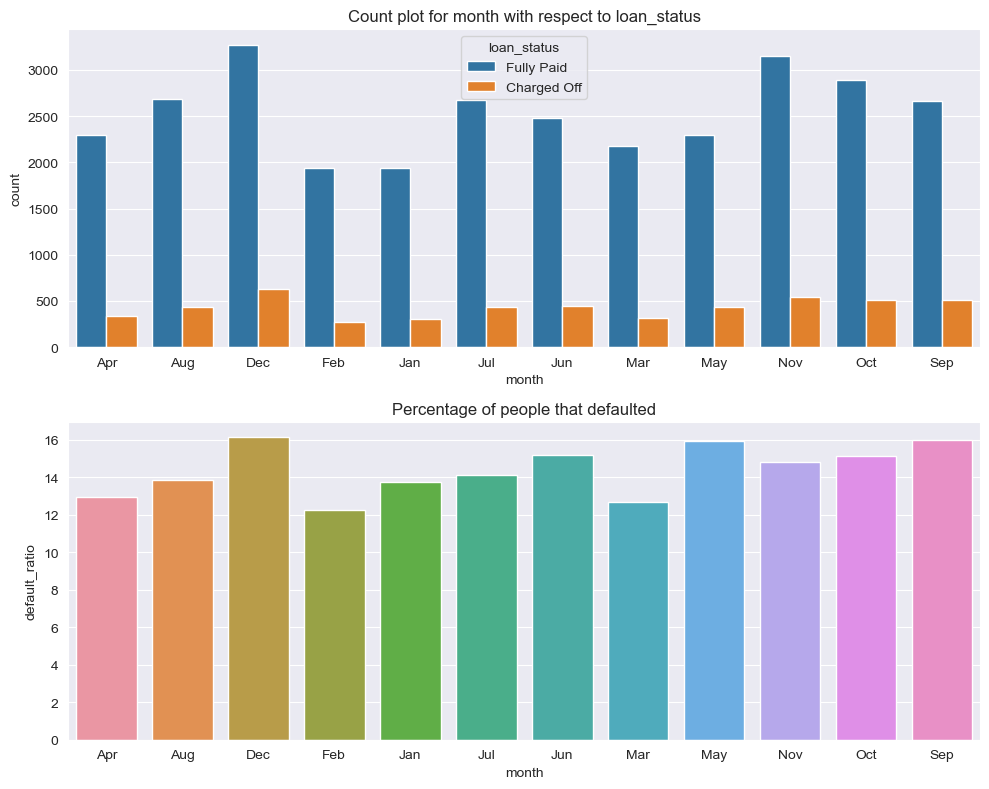

In [137]:
plotForCategoricalVariables(df, 'month')

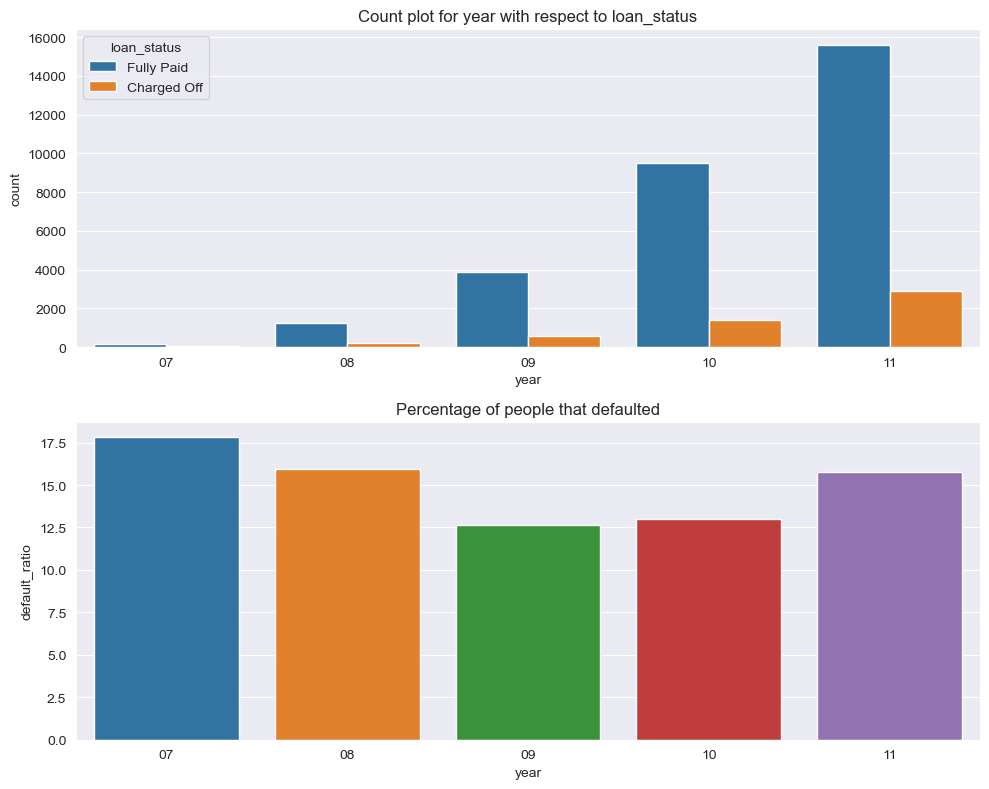

In [138]:
plotForCategoricalVariables(df, 'year')

There are no clear trends here.

## Bivariate analysis

For bivariate analysis of variables, we usually use scatter plots, but due to the data being skewed here, there wouldn't be a lot of insights that we can draw from scatter plots. Hence, we will mostly use pivot tables and heat maps by converting numeric values into categorical values using pandas qdcut. We will first write a custom function that will plot the heatmap for us. Just like univariate analysis, we will try and look at the percentage of people that defaulted rather than the count.

In [147]:
def plotHeatMap(col1, col2):
    df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    df[col2+'_bucket']=pd.qcut(df[col2], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    paid_pivot = pd.pivot_table(data=df[df['loan_status']=='Fully Paid'], index=col1+'_bucket', columns=col2+"_bucket", values='id', aggfunc='count')
    default_pivot = pd.pivot_table(data=df[df['loan_status']=='Charged Off'], index=col1+'_bucket', columns=col2+'_bucket', values='id', aggfunc='count')
    proportion_df = default_pivot.divide(paid_pivot.add(default_pivot))
    sns.heatmap(proportion_df, cmap='Greens')
    plt.show()

In [148]:
def plotHeatMapNumericCategorical(col1, col2):
    df[col1+'_bucket']=pd.qcut(df[col1], [0, 0.2, 0.4, 0.6, 0.8, 1], ["VL","L","M","H","VH"])
    paid_pivot = pd.pivot_table(data=df[df['loan_status']=='Fully Paid'], index=col1+'_bucket', columns=col2, values='id', aggfunc='count')
    default_pivot = pd.pivot_table(data=df[df['loan_status']=='Charged Off'], index=col1+'_bucket', columns=col2, values='id', aggfunc='count')
    proportion_df = default_pivot.divide(paid_pivot.add(default_pivot))
    proportion_df.index = pd.CategoricalIndex(proportion_df.index, categories= ["VL", "L", "M", "H", "VH"])
    sns.heatmap(proportion_df, cmap='Greens')
    plt.show()

## Int_Rate vs Annual_Inc

The reason we would like to compare the interest rate to the annual income is because, lower annual incomes will most likely not be able to repay loans at a high interest rate. Similarly, people with a very high annual income are more likely to easily repay loans.

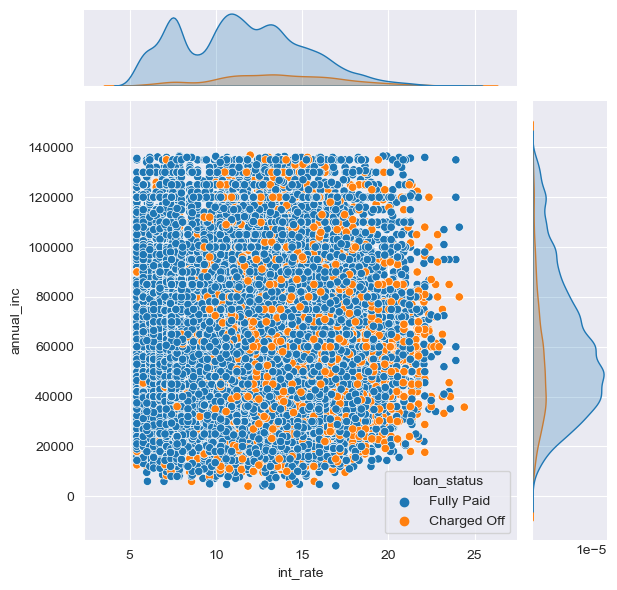

In [149]:
sns.jointplot(data=df, x='int_rate', y='annual_inc', hue='loan_status')

We can observe that at a low interest rate, very few people default. But as interest rates increase, we see default across all annual incomes. Let's evaluate the proportions using a heatmap.

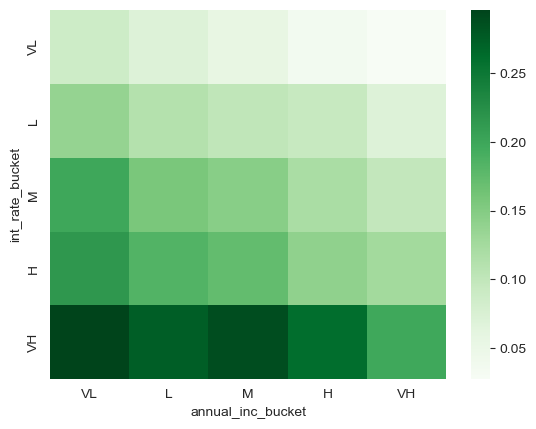

In [151]:
plotHeatMap('int_rate','annual_inc')

This heatmap clearly shows that as interest rates increase people with lower income are more often never able to repay the loan, people with higher incomes too default but a lower percentage of them. The heatmap shows that for default **Interest rate is inversely proportional to the annual income. Lower annual income and High interest rates default. Higher annual income, lower interest rates are able to repay the loan**.

## int_rate vs grade 

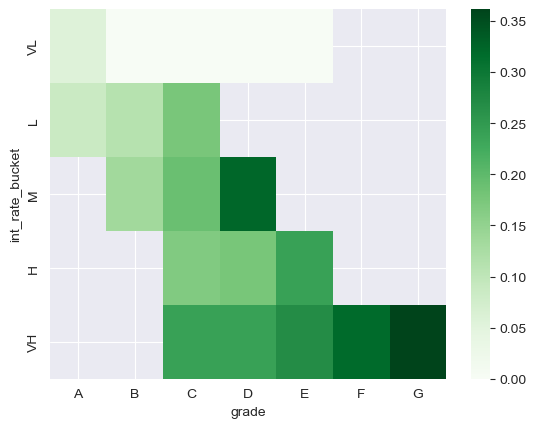

In [155]:
plotHeatMapNumericCategorical('int_rate','grade')

We already know from univariate analysis that high `int_rate` can lead to defaults. Here we also see that, at a higher interest rates, customers with a bad grades or riskier grades tend to default.

## int_rate vs sub_grade

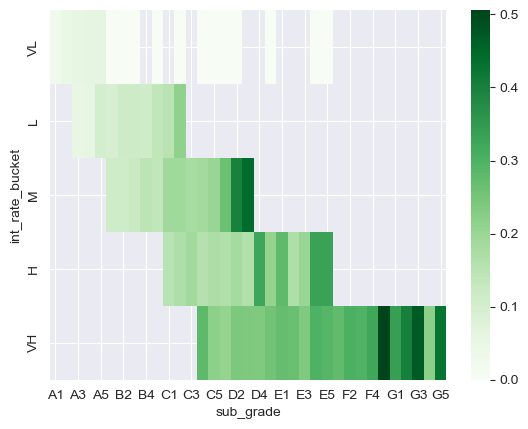

In [156]:
plotHeatMapNumericCategorical('int_rate','sub_grade')

We already know from univariate analysis that high int_rate can lead to defaults. Here we also see that, at a higher interest rates, customers with a bad sub_grades or riskier sub_grades tend to default.

## Revol_Util vs Grade

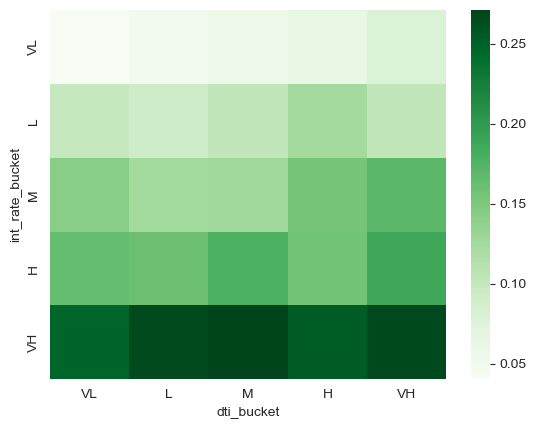

In [166]:
plotHeatMap('int_rate', 'dti')